In [1]:
#!pip install tensorflow==2.0.0b1

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
#!wget --no-check-certificate \
#    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#    -O /tmp/daily-min-temperatures.csv

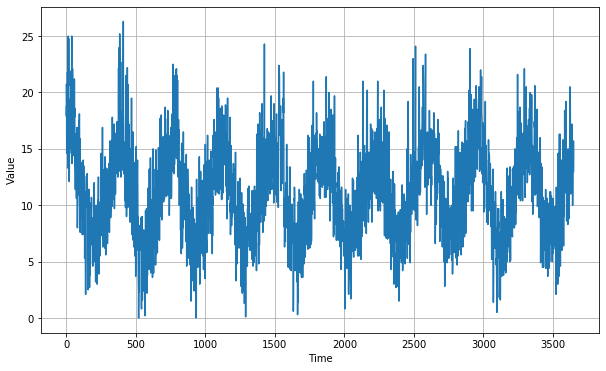

In [5]:
import csv
time_step = []
temps = []

with open('./tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    cnt = 0 
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(cnt)
        cnt+=1
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 4s 444ms/step - loss: 31.1551 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 0s 32ms/step - loss: 30.5849 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 0s 34ms/step - loss: 29.6259 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 0s 32ms/step - loss: 28.5432 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 0s 34ms/step - loss: 27.2554 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 0s 32ms/step - loss: 25.4769 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 0s 35ms/step - loss: 23.3469 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 0s 35ms/step - loss: 20.5459 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 0s 34ms/step - loss: 17.2022 - mae: 17.8083
Epoch 10/100
10/10 [====

10/10 [==============================] - 0s 49ms/step - loss: 5.7191 - mae: 6.1771
Epoch 86/100
10/10 [==============================] - 0s 43ms/step - loss: 6.2387 - mae: 6.7275
Epoch 87/100
10/10 [==============================] - 0s 45ms/step - loss: 6.7118 - mae: 7.3128
Epoch 88/100
10/10 [==============================] - 0s 38ms/step - loss: 19.2610 - mae: 19.3823
Epoch 89/100
10/10 [==============================] - 0s 38ms/step - loss: 8.9332 - mae: 9.1604
Epoch 90/100
10/10 [==============================] - 0s 39ms/step - loss: 18.4256 - mae: 19.1397
Epoch 91/100
10/10 [==============================] - 0s 36ms/step - loss: 26.4301 - mae: 27.2800
Epoch 92/100
10/10 [==============================] - 0s 36ms/step - loss: 27.7537 - mae: 29.2719
Epoch 93/100
10/10 [==============================] - 0s 36ms/step - loss: 54.4080 - mae: 55.8384
Epoch 94/100
10/10 [==============================] - 0s 36ms/step - loss: 26.9279 - mae: 28.4855
Epoch 95/100
10/10 [=====================

[1e-08, 0.0001, 0, 60]

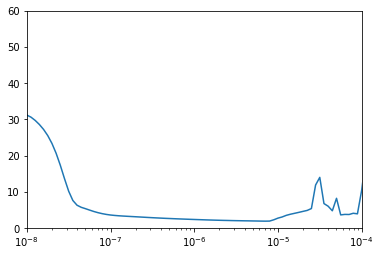

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/500
25/25 [==============================] - 3s 106ms/step - loss: 9.9672 - mae: 10.5788
Epoch 2/500
25/25 [==============================] - 0s 19ms/step - loss: 2.5740 - mae: 3.0496
Epoch 3/500
25/25 [==============================] - 0s 19ms/step - loss: 1.9326 - mae: 2.3879
Epoch 4/500
25/25 [==============================] - 0s 18ms/step - loss: 1.8647 - mae: 2.3160
Epoch 5/500
25/25 [==============================] - 0s 18ms/step - loss: 1.8189 - mae: 2.2715
Epoch 6/500
25/25 [==============================] - 0s 19ms/step - loss: 1.7909 - mae: 2.2419
Epoch 7/500
25/25 [==============================] - 0s 18ms/step - loss: 1.7627 - mae: 2.2129
Epoch 8/500
25/25 [==============================] - 0s 18ms/step - loss: 1.7430 - mae: 2.1938
Epoch 9/500
25/25 [==============================] - 0s 18ms/step - loss: 1.7178 - mae: 2.1687
Epoch 10/500
25/25 [==============================] - 0s 18ms/step - loss: 1.6983 - mae: 2.1483
Epoch 11/500
25/25 [===========================

25/25 [==============================] - 0s 18ms/step - loss: 1.5035 - mae: 1.9456
Epoch 87/500
25/25 [==============================] - 0s 18ms/step - loss: 1.5029 - mae: 1.9447
Epoch 88/500
25/25 [==============================] - 0s 18ms/step - loss: 1.5043 - mae: 1.9457
Epoch 89/500
25/25 [==============================] - 0s 18ms/step - loss: 1.5004 - mae: 1.9436
Epoch 90/500
25/25 [==============================] - 0s 18ms/step - loss: 1.5022 - mae: 1.9429
Epoch 91/500
25/25 [==============================] - 0s 18ms/step - loss: 1.5017 - mae: 1.9443
Epoch 92/500
25/25 [==============================] - 0s 19ms/step - loss: 1.5015 - mae: 1.9437
Epoch 93/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4985 - mae: 1.9408
Epoch 94/500
25/25 [==============================] - 0s 19ms/step - loss: 1.4975 - mae: 1.9394
Epoch 95/500
25/25 [==============================] - 1s 20ms/step - loss: 1.4954 - mae: 1.9378
Epoch 96/500
25/25 [==============================] -

25/25 [==============================] - 0s 18ms/step - loss: 1.4741 - mae: 1.9140
Epoch 171/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4789 - mae: 1.9202
Epoch 172/500
25/25 [==============================] - 0s 17ms/step - loss: 1.4735 - mae: 1.9134
Epoch 173/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4736 - mae: 1.9146
Epoch 174/500
25/25 [==============================] - 0s 17ms/step - loss: 1.4776 - mae: 1.9202
Epoch 175/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4762 - mae: 1.9163
Epoch 176/500
25/25 [==============================] - 0s 17ms/step - loss: 1.4750 - mae: 1.9154
Epoch 177/500
25/25 [==============================] - 0s 17ms/step - loss: 1.4738 - mae: 1.9140
Epoch 178/500
25/25 [==============================] - 0s 17ms/step - loss: 1.4740 - mae: 1.9144
Epoch 179/500
25/25 [==============================] - 0s 17ms/step - loss: 1.4736 - mae: 1.9134
Epoch 180/500
25/25 [=======================

25/25 [==============================] - 0s 17ms/step - loss: 1.4601 - mae: 1.9004
Epoch 255/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4690 - mae: 1.9088
Epoch 256/500
25/25 [==============================] - 0s 17ms/step - loss: 1.4664 - mae: 1.9076
Epoch 257/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4608 - mae: 1.9004
Epoch 258/500
25/25 [==============================] - 0s 19ms/step - loss: 1.4599 - mae: 1.8995
Epoch 259/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4591 - mae: 1.8992
Epoch 260/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4672 - mae: 1.9079
Epoch 261/500
25/25 [==============================] - 0s 17ms/step - loss: 1.4601 - mae: 1.8988
Epoch 262/500
25/25 [==============================] - 0s 17ms/step - loss: 1.4599 - mae: 1.8993
Epoch 263/500
25/25 [==============================] - 0s 17ms/step - loss: 1.4632 - mae: 1.9030
Epoch 264/500
25/25 [=======================

25/25 [==============================] - 0s 19ms/step - loss: 1.4492 - mae: 1.8899
Epoch 339/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4533 - mae: 1.8929
Epoch 340/500
25/25 [==============================] - 0s 19ms/step - loss: 1.4528 - mae: 1.8905
Epoch 341/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4540 - mae: 1.8925
Epoch 342/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4485 - mae: 1.8881
Epoch 343/500
25/25 [==============================] - 0s 19ms/step - loss: 1.4505 - mae: 1.8904
Epoch 344/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4502 - mae: 1.8892
Epoch 345/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4546 - mae: 1.8913
Epoch 346/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4515 - mae: 1.8910
Epoch 347/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4588 - mae: 1.8957
Epoch 348/500
25/25 [=======================

25/25 [==============================] - 1s 21ms/step - loss: 1.4451 - mae: 1.8840
Epoch 423/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4438 - mae: 1.8829
Epoch 424/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4408 - mae: 1.8812
Epoch 425/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4437 - mae: 1.8822
Epoch 426/500
25/25 [==============================] - 0s 19ms/step - loss: 1.4483 - mae: 1.8856
Epoch 427/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4454 - mae: 1.8840
Epoch 428/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4447 - mae: 1.8825
Epoch 429/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4424 - mae: 1.8810
Epoch 430/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4486 - mae: 1.8879
Epoch 431/500
25/25 [==============================] - 0s 18ms/step - loss: 1.4534 - mae: 1.8936
Epoch 432/500
25/25 [=======================

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

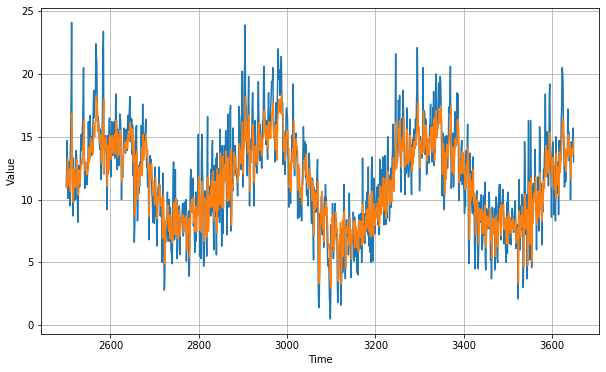

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.779856

In [15]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.320025 10.929364 12.201241 ... 13.590222 13.676396 14.720217]
